In [1]:
import pandas as pd

In [2]:
# Read datasets into pandas dataframes
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# See unique values in keyword and location columns to have an idea about the data
for col in train_df.columns[1:len(train_df.columns)-2]:
    print('{} values of {} column: {} \n '.format(len(train_df[col].value_counts()), col, train_df[col].unique()))

221 values of keyword column: [nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation'

In [5]:
# Get list of keywords with their count of fake disaster tweets, sort the list in descending order
keywords= [(i, len(train_df[(train_df['keyword']==i) & (train_df['target']==0)])) for i in train_df['keyword'].unique()]
keywords.sort(key = lambda x: x[1], reverse=True) 

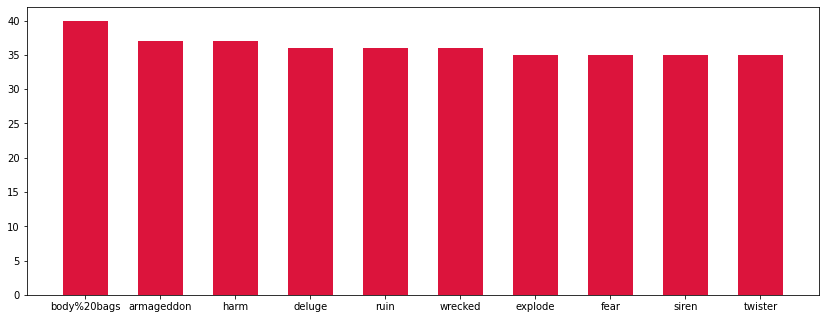

In [6]:
# Plot bar graph of keywords with the most fake disaster tweets
x, y = (zip(*keywords))

x = [str(i) for i in (x)][:10]
y = [int(i) for i in (y)][:10]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(11,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(x,y, width=0.6, color='#DC143C')
plt.show()

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [8]:
# download list of stopwords (only once; need not run it again)

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniekan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aniekan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words('english'))
import regex as re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# Function to preprocess data with Gensim
def preprocess_gensim(text):
    # Remove non-alphanumeric characters from data
    text = [re.sub(r'[^a-zA-Z0-9]', ' ', text) for text in text]
    
    # Lemmatize, stem and tokenize words in the dataset, removing stopwords
    text = [(PorterStemmer().stem(WordNetLemmatizer(). lemmatize(w, pos='v')) )for w in text]
    result = [[token for token in gensim.utils.simple_preprocess(sentence) if not token in 
              gensim.parsing.preprocessing.STOPWORDS and len(token) > 3] for sentence in text]
    return result

In [10]:
# NTLK stopwords vs. Gensim stopwords
print('NTLK stopwords: {} \n \n \n Gensim stopwords: {}'.format(stop_words, gensim.parsing.preprocessing.STOPWORDS))

NTLK stopwords: {'there', 'can', 'shan', 'that', 'now', 'yourself', 'themselves', 'any', 'ain', 'because', 'shouldn', 'between', 'so', 'wasn', 'from', 'while', 'ma', "should've", 'these', 'again', 'at', 'be', 'y', 'some', 'himself', 'each', 'hadn', 'couldn', "she's", "you'll", 'few', 'about', 'd', 'needn', 'isn', 'other', "mustn't", 'does', 'is', 'theirs', 'his', 'to', 'here', 'haven', 'ours', 'we', 'yourselves', 'as', "you'd", 'its', 'into', 'below', 'yours', 'further', "mightn't", "needn't", 'me', 'did', 'on', 'don', "you're", 'herself', 'weren', 'won', 'were', 'the', 'nor', 've', 'not', 'once', 'you', 'off', 'itself', 'has', "won't", 'such', 'down', 'they', 'than', 'mightn', 'those', 'under', 'been', 'myself', 'and', 'wouldn', 'them', 'during', 'your', 'do', "that'll", 'had', "haven't", 'her', 'both', "isn't", 'hasn', 'where', 'in', 'o', 'of', "shan't", 'same', 'what', 'but', 'only', 'over', 'it', 'him', 'until', "hasn't", "shouldn't", 'i', 'was', 'if', "doesn't", 'most', "couldn't"

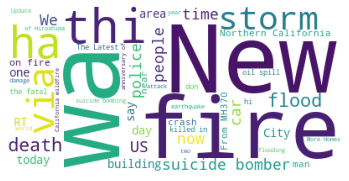

In [11]:
from wordcloud import WordCloud, STOPWORDS

# Adding more stopwords unique to the data to the WordCloud stopwords list
additional_wordcloud_stopwords = ['http', 'https', 'co', 'amp', 'you', 'to', 'us', 'will']

#Create a WordCloud of real disaster tweets
real_data = train_df[train_df['target'] == 1]
combined_real_data = real_data['text'].tolist()
combined_real_data = [re.sub(r'[^a-zA-Z0-9]', ' ', text) for text in combined_real_data]
combined_real_data = " ".join([review for review in combined_real_data])

wc = WordCloud(background_color='white', max_words=50,
              stopwords=STOPWORDS.update(additional_wordcloud_stopwords))

plt.imshow(wc.generate(combined_real_data))
plt.axis('off')
plt.show()

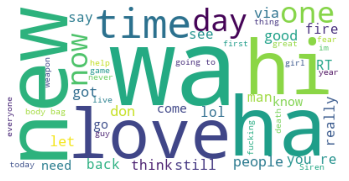

In [12]:
#Create a WordCloud of fake disaster tweets
fake_data = train_df[train_df['target'] == 0]
combined_fake_data = fake_data['text'].tolist()
combined_fake_data = [re.sub(r'[^a-zA-Z0-9]', ' ', text) for text in combined_fake_data]
combined_fake_data = " ".join([review for review in combined_fake_data])

wc = WordCloud(background_color='white', max_words=50,
              stopwords=STOPWORDS.update(additional_wordcloud_stopwords))

plt.imshow(wc.generate(combined_fake_data))
plt.axis('off')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

#Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train_df['text'].to_list(), train_df['target'].to_list(),
                                                    random_state=0)
# Carry out preprocessing on text data
words_train, words_test = preprocess_gensim(X_train), preprocess_gensim(X_test)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract Bag-of-Words (BoW)
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
features_train = vectorizer.fit_transform(words_train).toarray()

features_test = vectorizer.transform(words_test).toarray()

# Create a vocabulary from the dataset
vocabulary = vectorizer.vocabulary_

In [15]:
import random

# View random words in the vocabulary and confirm BoW representation of train and test data
print("Vocabulary: {} words".format(len(vocabulary)))
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))
print('\n')
print(features_train[0])
print(features_test[0])

Vocabulary: 15699 words
Sample words: ['jackperu', 'iniqzfyioi', 'dreamer', 'otrwz', 'glenn', 'funny', 'swear', 'parksboardfacts']


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [16]:
'''
Zipf's law
Zipf's law, named after the famous American linguist George Zipf, 
is an empirical law stating that given a large collection of documents, 
the frequency of any word is inversely proportional to its rank in the frequency table. 
In the figure below we plot number of appearances of each word in our training set against its rank.
'''

"\nZipf's law\nZipf's law, named after the famous American linguist George Zipf, \nis an empirical law stating that given a large collection of documents, \nthe frequency of any word is inversely proportional to its rank in the frequency table. \nIn the figure below we plot number of appearances of each word in our training set against its rank.\n"

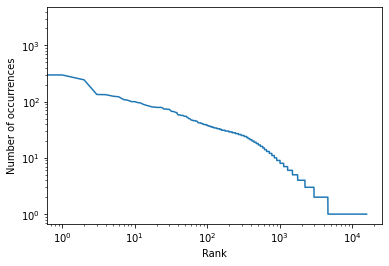

In [17]:
import numpy as np

# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [18]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=0)
features_test = pr.normalize(features_test, axis=0)

In [19]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
nb = GaussianNB()

nb.fit(features_train, y_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        nb.__class__.__name__,
        nb.score(features_train, y_train),
        nb.score(features_test, y_test)))


[GaussianNB] Accuracy: train = 0.9525310912594149, test = 0.6113445378151261


In [20]:
# Try Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(cv=5, scoring='accuracy', verbose=3, random_state=0, max_iter=1000)

logreg.fit(features_train, y_train)

print("[{}] Accuracy: train = {}, test = {}".format(
        logreg.__class__.__name__,
        logreg.score(features_train, y_train),
        logreg.score(features_test, y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.6min finished


[LogisticRegressionCV] Accuracy: train = 0.9919425468558416, test = 0.7909663865546218


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=5, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(features_train, y_train)

print('Accuracy of the GBM on training set: {:.3f}'.format(gbc.score(features_train, y_train)))
print('Accuracy of the GBM on test set: {0:.3f}'.format(gbc.score(features_test, y_test)))

Accuracy of the GBM on training set: 0.640
Accuracy of the GBM on test set: 0.666


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
cv_method = RepeatedStratifiedKFold(n_splits=2, 
                                    n_repeats=3, 
                                    random_state=0)

gs_NB = GridSearchCV(estimator=nb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')


gs_NB.fit(features_train, y_train);

Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.6min finished


In [23]:
print(gs_NB.best_params_)
print(gs_NB.best_score_)

{'var_smoothing': 0.01}
0.6142350368242194


In [24]:
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression


logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=1000, random_state=0)
hyperparameters = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
param_grid = {'C': [100, 10, 1.0, 0.1, 0.01]}
k = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=0)

grid = GridSearchCV(logistic, param_grid=param_grid, cv=k, n_jobs=4, verbose=1)
grid.fit(features_train, y_train)

print('Best C:', grid.best_params_)

Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  8.2min finished


Best C: {'C': 100}


In [25]:
print('Accuracy of the GridSearch on training set: {:.3f}'.format(grid.score(features_train, y_train)))
print('Accuracy of the GridSearch on test set: {0:.3f}'.format(grid.score(features_test, y_test)))

Accuracy of the GridSearch on training set: 0.989
Accuracy of the GridSearch on test set: 0.795


In [26]:
from sklearn.model_selection import cross_val_score   #Additional scklearn functions

cv_score1 = cross_val_score(gbc, features_train, y_train, cv=3, scoring='roc_auc')
cv_score2 = cross_val_score(nb, features_train, y_train, cv=3, scoring='roc_auc')
cv_score3 = cross_val_score(logreg, features_train, y_train, cv=3, scoring='roc_auc')
cv_score4 = cross_val_score(grid, features_train, y_train, cv=3, scoring='roc_auc')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished


Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  3.8min finished


Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  4.8min finished


Fitting 6 folds for each of 5 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  4.2min finished


In [27]:
print(cv_score1)
print(cv_score2)
print(cv_score3)
print(cv_score4)

[0.67282791 0.66312475 0.6428226 ]
[0.62348176 0.62625232 0.62875156]
[0.81455557 0.82691516 0.82859388]
[0.82217687 0.83236633 0.83160817]


In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

y_pred1 = nb.predict(features_test)
y_pred2 = logreg.predict(features_test)
y_pred3 = grid.predict(features_test)


print("---Test Set Results---")
print("Accuracy with Gaussian: {}".format(accuracy_score(y_test, y_pred1)))
print("Accuracy with Logistic regression: {}".format(accuracy_score(y_test, y_pred2)))
print("Accuracy with tuned Logistic regression: {}".format(accuracy_score(y_test, y_pred3)))

print("AUC Score with Gaussian: {}".format(roc_auc_score(y_test, y_pred1)))
print("AUC Score with Logistic regression: {}".format(roc_auc_score(y_test, y_pred2)))
print("AUC Score with tuned Logistic regression: {}".format(roc_auc_score(y_test, y_pred3)))


print('Gaussian \n {}'.format(classification_report(y_test, y_pred1)))
print('Logistic regression \n {}'.format(classification_report(y_test, y_pred2)))
print('Tuned Logistic regression \n {}'.format(classification_report(y_test, y_pred3)))

---Test Set Results---
Accuracy with Gaussian: 0.6113445378151261
Accuracy with Logistic regression: 0.7909663865546218
Accuracy with tuned Logistic regression: 0.7951680672268907
AUC Score with Gaussian: 0.6332622673780063
AUC Score with Logistic regression: 0.7787740612663341
AUC Score with tuned Logistic regression: 0.7827387935108963
Gaussian 
               precision    recall  f1-score   support

           0       0.75      0.50      0.60      1107
           1       0.52      0.77      0.62       797

    accuracy                           0.61      1904
   macro avg       0.64      0.63      0.61      1904
weighted avg       0.65      0.61      0.61      1904

Logistic regression 
               precision    recall  f1-score   support

           0       0.80      0.85      0.83      1107
           1       0.78      0.70      0.74       797

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79     

In [29]:
test = test_df['text'].to_list()

In [30]:
test = preprocess_gensim(test)

In [31]:
test = vectorizer.transform(test).toarray()

In [32]:
test_pred = grid.predict(test)

In [33]:
test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [34]:
# Switch to RNNs

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(words_train)

X_train = tokenizer.texts_to_sequences(words_train)
X_test = tokenizer.texts_to_sequences(words_test)

vocabulary_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(words_train[2])

Using TensorFlow backend.


['electricity', 'stop', 'scofield', 'nigga', 'survived', 'hotbox', 'sona']


In [35]:
# Find the maximum number of words in a tweet

max_length = 0
for i,x in enumerate(words_train):
    if len(words_train[i]) > max_length:
        max_length = len(words_train[i])

print(max_length)

20


In [36]:
from keras.preprocessing.sequence import pad_sequences 

# Set the maximum number of words per document (for both training and testing) by padding sequences 
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [37]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocabulary_size, 
                           output_dim=embedding_dim, 
                           input_length=max_length))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            785000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 785,521
Trainable params: 785,521
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Fit and evaluate the model
model.fit(X_train, y_train, epochs=50, verbose=False, validation_data=(X_test, y_test), batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 0.9821
Testing Accuracy:  0.7652


In [39]:
import os

# Save the model
cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)

model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

In [40]:
! pip freeze > requirements.txt